# Abu Dhabi 2021 Minisector Comparison

<p align="center">
 <img src = "AbuDhabi.jpeg">
</p>


In this notebook, we will be comparing the minisector performance of the Abu Dhabi 2021 season. Specifically we will analyze the qualification session, one of the most spectacular ones of the season.

Max Verstappen and Lewis Hamilton have been going neck-and-neck all season, and nothing was different during the Abu Dhabi Grand Prix.

In contrast with what happened in the earlier practice session, Verstappen beats Hamilton to pole position with $0.371$ seconds. We will analyze this lap in order to find differences between the two drivers.

### Step 1: Setting up the basics

As first thing we import the libraries we need. If you don’t have any of these installed, make sure to pip install it in your command line, by for example doing `pip install fastf1` .

In [4]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

# Enable the cache
ff1.Cache.enable_cache('/home/ilazza/Documenti/Formula1_Data_Analysis/cache') 

# Setup plotting
plotting.setup_mpl()

# Get rid of some pandas warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None

Since, as you will notice later, it can take a few seconds to load the data from the qualification session, we want to cache that data so that we can quickly access it later. Also, we run a method coming from the `fastf1` library that sets up the plotting we will do in matplotlib.

### Step 2: Loading the data

Now it’s time to collect the data. First, we select our session using `ff1.get_session(year, race, session)` . 

The session we are interested in is, in this case, Q for qualification. If you’d like to get any other session, you can also choose FP1/FP2/FP3, or R. After specifying the session, we can load the laps.

In [5]:
#Load the session data
quali = ff1.get_session(2021, 'Abu Dhabi', 'Q')

#Get the laps
laps = quali.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Abu Dhabi Grand Prix - Qualifying [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching 

## Step 2.1: Processing the data

In the world of data, a dataset is (unofrtunately) almost never reasy *out-of-the-box*. It always needs some data transformtation to enrich the data or to re-format the data into the shape we want it in. 

### Expand the data

We start with selecting the specific data we require, and adding to it what we need. This involves selecting the fastest laps from Hamilton and Verstappen, getting their telemetry data, adding the distance variable so we can compare the speeds over the distance, and merging both telemetry DataFrames into a single DataFrame called `telemetry` .

In [10]:
#Select the laps from Hamilton and Verstaappen
laps_ver = laps.pick_driver('VER')
laps_ham = laps.pick_driver('HAM')

#Get the telemetry data from their fastest laps
fastest_ver = laps_ver.pick_fastest().get_telemetry().add_distance()
fastest_ham = laps_ham.pick_fastest().get_telemetry().add_distance()

#Since the telemetry data does not have a variable that indicates the driver, we add it manually
fastest_ver['Driver'] = 'VER'
fastest_ham['Driver'] = 'HAM'

#Merge both lap telemetries into one dataframe

telemetry = fastest_ver.append(fastest_ham)




In [14]:
telemetry.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance,Driver
2,2021-12-11 13:52:51.006,0 days 01:07:50.822000,,366.041667,0 days 00:00:00,11049,234,5,100,0,8,interpolation,0.000075,OnTrack,532,2076,-241,0.000000,VER
3,2021-12-11 13:52:51.029,0 days 01:07:50.845000,,366.041667,0 days 00:00:00.023000,11005,235,5,100,0,8,pos,0.000368,OnTrack,546,2077,-239,1.501389,VER
4,2021-12-11 13:52:51.036,0 days 01:07:50.852000,,366.041667,0 days 00:00:00.030000,10918,238,6,100,0,8,car,0.000458,OnTrack,550,2077,-238,1.964167,VER
5,2021-12-11 13:52:51.249,0 days 01:07:51.065000,,366.041667,0 days 00:00:00.243000,11070,240,6,100,0,8,pos,0.003206,OnTrack,692,2096,-239,16.164167,VER
6,2021-12-11 13:52:51.276,0 days 01:07:51.092000,11,366.041667,0 days 00:00:00.270000,11222,243,6,100,0,8,car,0.003559,OnTrack,710,2098,-239,17.986667,VER


### Creating minisectors

Since we’re comparing the speeds across minisectors, we first need to define the minisectors. We do this by cutting the total length of the track into 25 (this number can be changed) equally-sized chunks, which will form the minisectors.

In [15]:
#Chosen number 25 mini-sectors
num_minisectors = 25

#Grab the maximum value of distance that we have in our telemetry data 
total_distance = telemetry['Distance'].max()

#Generate equally sized mini-sectors
minisector_length = total_distance / num_minisectors


Now we know length of each minisector, we want to create a list that contains all the distances at which the next minisector starts.

In [16]:
#Initialize the minisector variable, with 0 (meters) as starting point
minisectors = [0]

#Add multiple of the minisector_length to the minisectors
for i in range(0, (num_minisectors -1)):
    minisectors.append(minisector_length * (i+1))


And finally, we want to assign every row that exists in the dataset a minisector. 

In other words, *in which minisector was the car at the moment the datapoint was recorded?* 

To do that, we create a column `Minisector` in the telemetry DataFrame, which looks the `Distance` up in the `minisector` variable we just created, to identify in which minisector we are.

In [19]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: ( int( (dist // minisector_length + 1)) )
                                                     )                              

### Calculate fastest driver per minisector

The last thing we need to do is calculating the fastest driver per minisector, so we can determine the color of the plot for that minisector. 

This, again, involves a few transformations to the data that like `groupby()` operations.

First, we calculate the average speed per driver per minisector, grouping by `Minisector` and `Driver`, taking the mean of the `Speed` column. 


In [20]:
#Calculate the average speed for each minisector

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()


In [23]:
average_speed.head(10)

,Minisector,Driver,Speed
0,1,HAM,260.615385
1,1,VER,260.461538
2,2,HAM,233.035714
3,2,VER,236.482759
4,3,HAM,219.600000
5,3,VER,216.766667
6,4,HAM,265.080000
7,4,VER,265.080000
8,5,HAM,279.173913
9,5,VER,279.869565


Then, we want to select the fastest driver per minisector. 

To do that, we use the `idxmax()` method, which returns the index of the row with the maximum value in the column we specify. 

In [31]:
#Select the fastest driver per minisector
#the one with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby('Minisector')['Speed'].idxmax()]

#Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver.drop(columns=['Speed']).rename(columns={'Driver': 'Fastest_driver'})

In [32]:
fastest_driver.head(10)

,Minisector,Fastest_driver
0,1,HAM
3,2,VER
4,3,HAM
6,4,HAM
9,5,VER
11,6,VER
12,7,HAM
14,8,HAM
17,9,VER
19,10,VER


The only remaining thing we need to do is to join the fastest driver per minisector with the full telemetry data, so that we can easily plot all the data later. 

In addition, we need to make sure that the `Distance` is properly sorted.

Last, but not least, we need to convert the driver abbreviation (e.g. “HAM”) to an integer value, since otherwise matplotlib won’t be able to deal with it.

In [33]:
# Join the fastest driver per minisector with the full telemetry
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == 'VER', 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == 'HAM', 'Fastest_driver_int'] = 2


## Step 3: Plotting the data

Finally it's time to plot the data.

* [Line 1–2] We extract the `x` and `y` value from every row, which tells us where exactly the car was on the track at that point in time. We will use this to draw the shape of the circuit.
  
* [Line 4–6] The x- and y-coordinates are combined so that they become points. These points are then used to form segments between those points.
  
* [Line 8–11] This is all about the coloring of the plot. `cmap` stands for `ColorMap`, which basically defines the colors of the plot. I chose for the ‘winter’ color scheme, since that one gives us something like the **Red Bull** vs. **Mercedes** colors.  
The previously defined `segments` will then take a color from the `Colormap`, and form a `LineCollection`, which is a collection of all the lines.
  
* [Line 15–17] This is where the plot gets drawn in the shape of the circuit. The `LineCollection` is added to the plot, and the labels are disabled on the x- and y-axes.
  
* [Line 19–21] This part adds the legend, which is the colorbar you will see on the right.

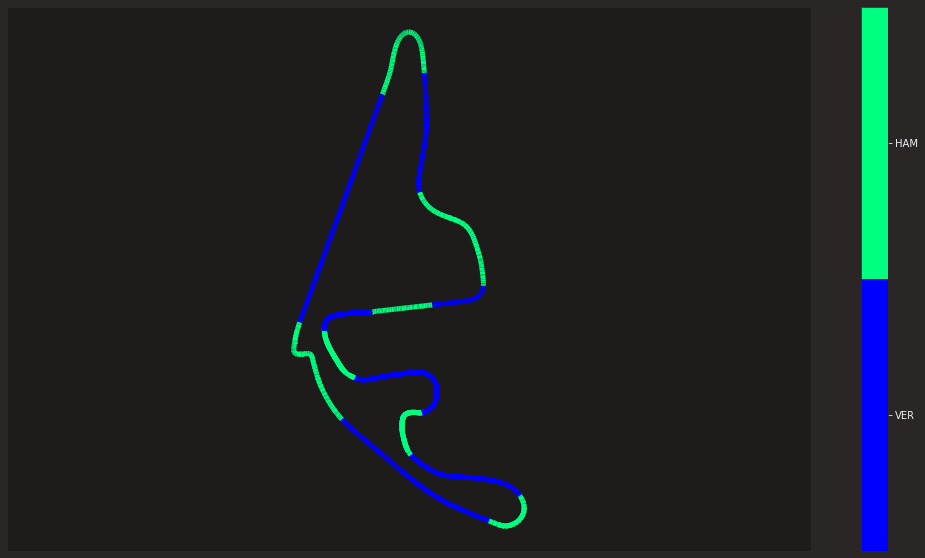

In [40]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2) 
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

cmap = cm.get_cmap('winter' , 2)
lc_comp = LineCollection(segments, cmap=cmap, norm=plt.Normalize(1, cmap.N+1))
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [18, 10]    #Making the plot a bit bigger

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,4))
cbar.set_ticks(np.arange(1.5, 9.5))
cbar.set_ticklabels(['VER', 'HAM'])

plt.show()



## Conclusions

From this figure we can see all the differences between the two drivers' performance during their fastest quali laps.

In particular the RedBull of Max Verstappen was faster than the Mercedes of Lewis Hamilton in most of all straights, while Lewis was faster in the slow curves.